In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2

import os, itertools, pickle
from pprint import pprint
from util import *
from putil import *
from config import *
%load_ext autoreload
%aimport util
%aimport putil
%aimport config
%autoreload 1

In [2]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
# https://docs.opencv.org/2.4.2/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

def get_chessboard(frame_paths, board_shape=(7, 9), min_interval=5, draw_visual=False):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    w, h = board_shape
    objp = np.zeros((w * h, 3), np.float32)
    objp[:, :2] = np.mgrid[:w, :h].T.reshape(-1, 2)

    point_dict = {} # maps frame_path to (3d point in real world space, 2d point in image plane)
    prev_key = -min_interval
    for frame_path in frame_paths:
        key = int(frame_path.split('_')[-1].rstrip('.jpg'))
        if key - prev_key < min_interval:
            remove(frame_path)
            continue
        if not os.path.exists(frame_path):
            continue
        img = cv2.imread(frame_path)
        gray = clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

        ret, corners = cv2.findChessboardCorners(gray, (w, h))
        if ret:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            if draw_visual:
                vis_dir = make_dir(os.path.dirname(frame_path) + '/visual/')
                vis_path = vis_dir + get_name(frame_path, ext=True)
                if not os.path.exists(vis_path):
                    cv2.drawChessboardCorners(img, board_shape, corners, ret)
                    cv2.imwrite(vis_path, img)
            
#             corner_img = cv2.drawChessboardCorners(img, (w, h), corners, True)
            print(frame_path)
            point_dict[frame_path] = (objp, corners)
            prev_key = key
        else:
            print('no', frame_path)
            remove(frame_path)
    return point_dict

def filter_nth(matrix, n):
    return np.array(matrix[::n])

# Generate and Select Frames

In [10]:
for camera_i in [3]:
    print('camera', camera_i)
    camera_dir = Calibrations + '%s/' % camera_i
    video_dir = camera_dir + 'video/'
    
    full_point_dict = {}
    for video_name, video_path in list_dir(video_dir, 'mp4', return_name=True):
        record_path = video_path + '.records'
        print('video', video_path)
        if os.path.exists(record_path):
            print('loading saved points')
            point_dict = load_pickle(record_path)
        else:
            print('reading')
            video_name_dir = video_dir + video_name + '/'
            if not os.path.exists(video_name_dir):
                video_to_frames(video_path, video_name_dir, nth=5)
            frame_paths = list_dir(video_name_dir, 'jpg')
            print('finding points on chessboard for %s frames' % len(frame_paths))
            board_shape = (6, 9) if camera_i == 5 and video_name == 'GOPR0073' else (7, 9)
            point_dict = get_chessboard(frame_paths, board_shape=board_shape, min_interval=1, draw_visual=True)

            while len(point_dict) != len(frame_paths):
                try: x = input() # input after removing unnecessary images
                except SyntaxError: break
                    
            remaining_paths = set(list_dir(video_name_dir, 'jpg'))
            point_dict = { path : point_dict[path] for path in remaining_paths }
            save_pickle(point_dict, record_path)
        full_point_dict.update(point_dict)
    print('found %s matches for camera' % len(full_point_dict))
    selected_dir = video_dir + 'selected/'
    selected_records = video_dir + 'selected.records'
    full_selected_paths = { (selected_dir + get_name(path, ext=True)) : path for path in full_point_dict }
    if not os.path.exists(selected_dir):
        make_dir(selected_dir)
        for p in set(full_selected_paths):
            shutil.copy(full_selected_paths[p], p)
    selected_point_dict = { p : full_point_dict[full_selected_paths[p]] for p in list_dir(selected_dir, 'jpg') }
    save_pickle(selected_point_dict, selected_records)
    print('keeping %s matches for camera' % len(selected_point_dict))

camera 3
video /mnt/c/Users/zhong/Desktop/bdd/calibrations/3/video/GOPR0059.MP4
loading saved points
video /mnt/c/Users/zhong/Desktop/bdd/calibrations/3/video/GOPR0070.MP4
loading saved points
found 37 matches for camera
keeping 37 matches for camera


# Optimize Params 

In [9]:
for camera_i in [2]:
    print('camera', camera_i)
    camera_dir = Calibrations + '%s/' % camera_i
    video_dir = camera_dir + 'video/'
    
    calibration = load_calibration(camera_i)
    if calibration:
        print('already calibrated')
        camera_matrix, dist_coef, new_camera_matrix = calibration
        rvecs, tvecs = load_rt_vecs(camera_i)
    else:
        full_point_dict = load_pickle(video_dir + 'selected.records')
        print('%s matches for camera' % len(full_point_dict))
        full_point_list = sorted(full_point_dict.items())
        object_points, image_points = zip(*(points for path, points in full_point_list))
        ret, camera_matrix, dist_coef, rvecs, tvecs = cv2.calibrateCamera(
            object_points, image_points, 
            (V_w, V_h), None, None,
            flags=cv2.CALIB_RATIONAL_MODEL
        )
        
        print('getting new camera matrix')
        new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coef, (V_w, V_h), 0, centerPrincipalPoint=1)
        if not any(roi):
            print('invalid calibration; zeros for roi')
            continue
        save_calibration(camera_i, camera_matrix, dist_coef, new_camera_matrix, rt_vecs=(rvecs, tvecs))
        print('generated new camera matrix')
        
    errors = {}
    for i, (path, (object_pt, image_pt)) in enumerate(full_point_list):
        image_points2, _ = cv2.projectPoints(object_pt, rvecs[i], tvecs[i], camera_matrix, dist_coef)
        error = cv2.norm(image_pt, image_points2, cv2.NORM_L2) / len(image_points2)
        errors[path] = error
    err_vals = errors.values()
    err_cutoff = sorted(err_vals)[int(len(err_vals) * 0.9)]
    pprint({ p : v for p, v in errors.items() if v > err_cutoff })
    
    print('Errors: mean=%s max=%s min=%s' % (np.mean(err_vals), np.max(err_vals), np.min(err_vals)))

camera 2
already calibrated
{'/mnt/c/Users/zhong/Desktop/bdd/calibrations/2/video/GOPR0104/GOPR0104_0001.jpg': 0.4585492202626758,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/2/video/GOPR0107/GOPR0107_0060.jpg': 1.2526315879076375,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/2/video/GOPR0113/GOPR0113_0126.jpg': 0.48462850172215705,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/2/video/GOPR0113/GOPR0113_0153.jpg': 0.47639536572807556}
Errors: mean=0.24817556874135285 max=1.2526315879076375 min=0.06754793084609217


# Alternative

In [33]:
camera_i = 6
camera_dir = Calibrations + '%s/' % camera_i
video_dir = camera_dir + 'video/'
for p in list_dir(video_dir, 'mp4'):
    video_to_frames(p, p[:-4], nth=1)

ffmpeg -i /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0057.MP4 -threads 4 -filter:v "select=not(mod(n\,1))" /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0057/GOPR0057_%04d.jpg -frames:v 1 -vsync vfr
ffmpeg -i /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0069.MP4 -threads 4 -filter:v "select=not(mod(n\,1))" /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0069/GOPR0069_%04d.jpg -frames:v 1 -vsync vfr
ffmpeg -i /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0070.MP4 -threads 4 -filter:v "select=not(mod(n\,1))" /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0070/GOPR0070_%04d.jpg -frames:v 1 -vsync vfr
ffmpeg -i /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0073.MP4 -threads 4 -filter:v "select=not(mod(n\,1))" /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0073/GOPR0073_%04d.jpg -frames:v 1 -vsync vfr
ffmpeg -i /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079.MP4 -threads 4 -filter:v "select=not(mod(

In [ ]:
# http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
# https://docs.opencv.org/2.4.2/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

def get_chessboard(frame_paths, board_shape=(7, 9), draw_visual=False):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    w, h = board_shape
    objp = np.zeros((w * h, 3), np.float32)
    objp[:, :2] = np.mgrid[:w, :h].T.reshape(-1, 2)

    point_dict = {} # maps frame_path to (3d point in real world space, 2d point in image plane)
    for frame_path in frame_paths:
        if not os.path.exists(frame_path):
            continue
        img = cv2.imread(frame_path)
        gray = clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

        ret, corners = cv2.findChessboardCorners(gray, (w, h))
        if ret:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            if draw_visual:
                vis_dir = make_dir(os.path.dirname(frame_path) + '/visual/')
                vis_path = vis_dir + get_name(frame_path, ext=True)
                if not os.path.exists(vis_path):
                    cv2.drawChessboardCorners(img, board_shape, corners, ret)
                    cv2.imwrite(vis_path, img)
            
#             corner_img = cv2.drawChessboardCorners(img, (w, h), corners, True)
            print('found', frame_path)
            point_dict[frame_path] = (objp, corners)
        else:
            print('no', frame_path)
#             remove(frame_path)
    return point_dict

camera_i = 6
camera_dir = Calibrations + '%s/' % camera_i
video_dir = camera_dir + 'video/'
selected_dir = video_dir + 'selected/'
selected_records = video_dir + 'selected.records'
if not os.path.exists(selected_records):
    frame_paths = list_dir(selected_dir, 'jpg')
    other_shape_filter = {
        '5/video/GOPR0073' : (6, 9),
    }
    shapes = {}
    for p in frame_paths:
        for f, s in other_shape_filter.items():
            if f in p:
                break
        else:
            s = (7, 9)
        shapes.setdefault(s, []).append(p)
    point_dict = {}
    for s, paths in shapes.items():
        point_dict.update(get_chessboard(paths, board_shape=s, draw_visual=True))
    save_pickle(point_dict, selected_records)

In [47]:
get_chessboard(['/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_%04d.jpg' % x for x in range(1305, 1320)], board_shape=(7, 9), draw_visual=True)

no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1305.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1306.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1307.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1308.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1309.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1310.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1311.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1312.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1313.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1314.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1315.jpg
no /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/GOPR0079/GOPR0079_1316.jpg
no /mnt/c/Users/

{}

In [50]:
camera_i = 6
print('camera', camera_i)
camera_dir = Calibrations + '%s/' % camera_i
video_dir = camera_dir + 'video/'

calibration = load_calibration(camera_i)
if calibration:
    print('already calibrated')
    camera_matrix, dist_coef, new_camera_matrix = calibration
    rvecs, tvecs = load_rt_vecs(camera_i)
else:
    full_point_dict = load_pickle(video_dir + 'selected.records')
    print('%s matches for camera' % len(full_point_dict))
    full_point_list = sorted(full_point_dict.items())
    object_points, image_points = zip(*(points for path, points in full_point_list))
    ret, camera_matrix, dist_coef, rvecs, tvecs = cv2.calibrateCamera(
        object_points, image_points, 
        (V_w, V_h), None, None,
        flags=cv2.CALIB_RATIONAL_MODEL
    )

    print('getting new camera matrix')
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coef, (V_w, V_h), 0, centerPrincipalPoint=1)
    if not any(roi):
        raise RuntimeError('invalid calibration; zeros for roi')
    save_calibration(camera_i, camera_matrix, dist_coef, new_camera_matrix, rt_vecs=(rvecs, tvecs))
    print('generated new camera matrix')

errors = {}
for i, (path, (object_pt, image_pt)) in enumerate(full_point_list):
    image_points2, _ = cv2.projectPoints(object_pt, rvecs[i], tvecs[i], camera_matrix, dist_coef)
    error = cv2.norm(image_pt, image_points2, cv2.NORM_L2) / len(image_points2)
    errors[path] = error
err_vals = errors.values()
err_cutoff = sorted(err_vals)[int(len(err_vals) * 0.9)]
pprint({ p : v for p, v in errors.items() if v > err_cutoff })

print('Errors: mean=%s max=%s min=%s' % (np.mean(err_vals), np.max(err_vals), np.min(err_vals)))

camera 6
73 matches for camera
getting new camera matrix
generated new camera matrix
{'/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/selected/GOPR0057_0198.jpg': 0.5394683623815593,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/selected/GOPR0069_0167.jpg': 0.5748149005144352,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/selected/GOPR0073_0548.jpg': 0.5500104265318241,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/selected/GOPR0073_0582.jpg': 0.790632034975933,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/selected/GOPR0073_0684.jpg': 0.8095131964331999,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/selected/GOPR0073_0729.jpg': 0.4602517343075586,
 '/mnt/c/Users/zhong/Desktop/bdd/calibrations/6/video/selected/GOPR0079_1686.jpg': 0.5671920755419196}
Errors: mean=0.2558749216097154 max=0.8095131964331999 min=0.05674067002226232


# Test

In [51]:
for camera_i in [6]:
    print('camera', camera_i)
    camera_dir = Calibrations + '%s/' % camera_i

    test_dir = camera_dir + 'test/'
    for v_name, v_path in list_dir(test_dir, 'mp4', return_name=True):
        if v_path.endswith('.output.mp4'):
            continue
        print('testing', v_path)
        shell('python undistort.py %s %s %s' % (v_path, camera_i, test_dir + v_name + '.output.mp4'), ignore_error=0)
print('done')

camera 6
testing /mnt/c/Users/zhong/Desktop/bdd/calibrations/6/test/test.mp4
done


In [3]:
from mpl_toolkits.mplot3d import Axes3D

def display_calibration_boards(camera_i):
    print('camera', camera_i)
    camera_dir = Calibrations + '%s/' % camera_i
    video_dir = camera_dir + 'video/'
    w, h = 7, 9
    objp = np.zeros((w * h, 3), np.float32)
    objp[:, :2] = np.mgrid[:w, :h].T.reshape(-1, 2)    
    rvecs, tvecs = load_rt_vecs(camera_i)
    print('%s images' % len(rvecs))
    
    def plot(azim=0):
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter([0], [0], [0], c='black')
        for rvec, tvec in zip(rvecs, tvecs):
            R, _ = cv2.Rodrigues(rvec)
            xs, ys, zs = np.dot(R, objp.T) + tvec
            ax.scatter(xs, ys, zs, s=1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.view_init(elev=0, azim=azim)
        plt.savefig(camera_dir + 'board_locations_%s.jpg' % azim)
        plt.show()
    plot(0)
    plot(270)

camera 1
44 images


<IPython.core.display.Javascript object>


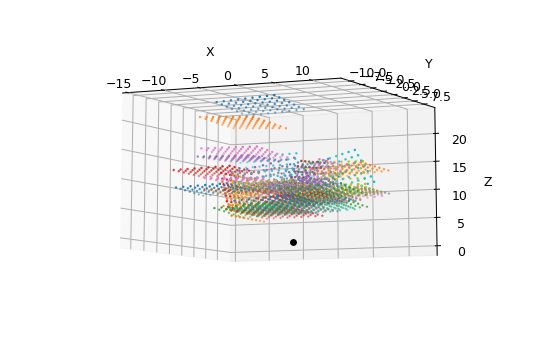

In [8]:
display_calibration_boards(1)

camera 2
55 images


<IPython.core.display.Javascript object>


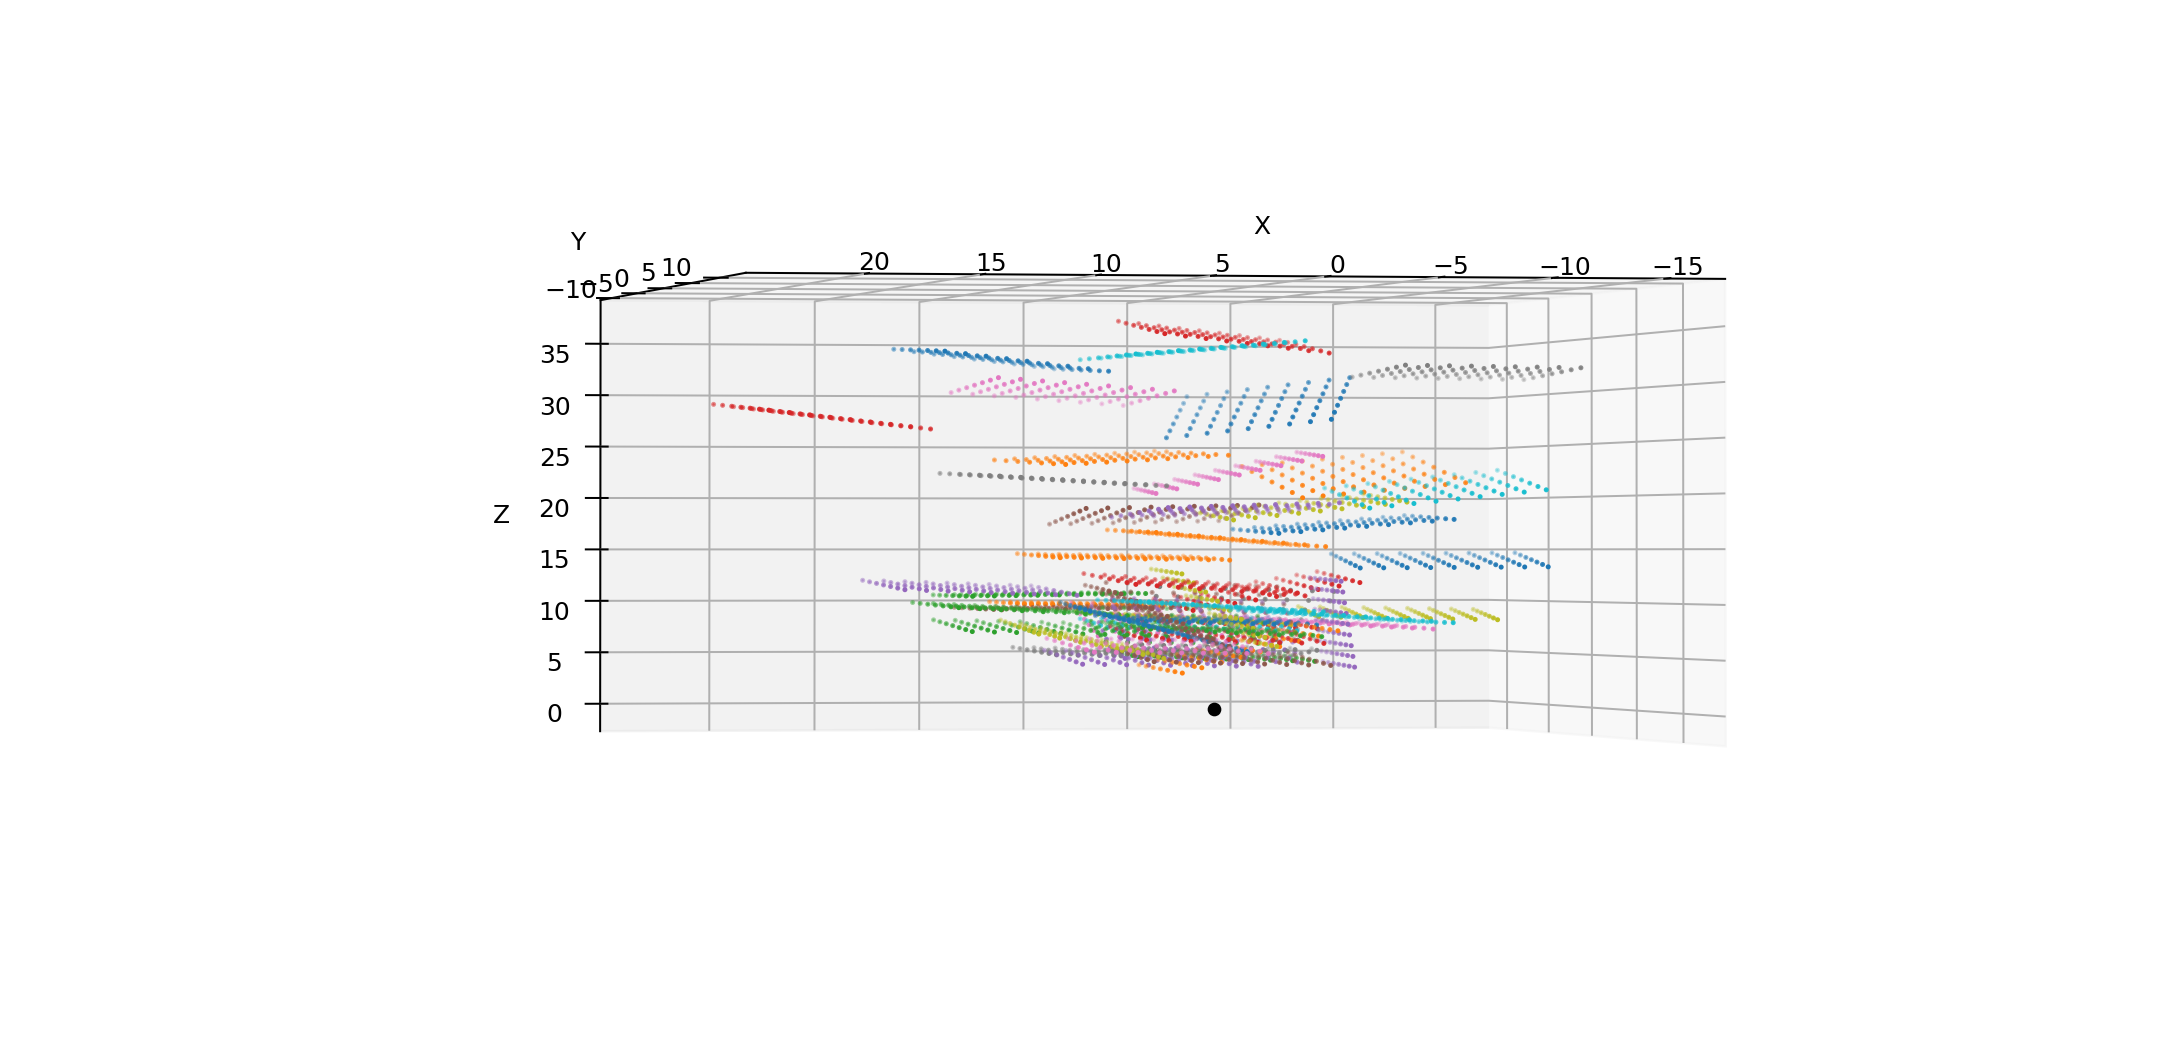

In [7]:
display_calibration_boards(2)

camera 3
46 images


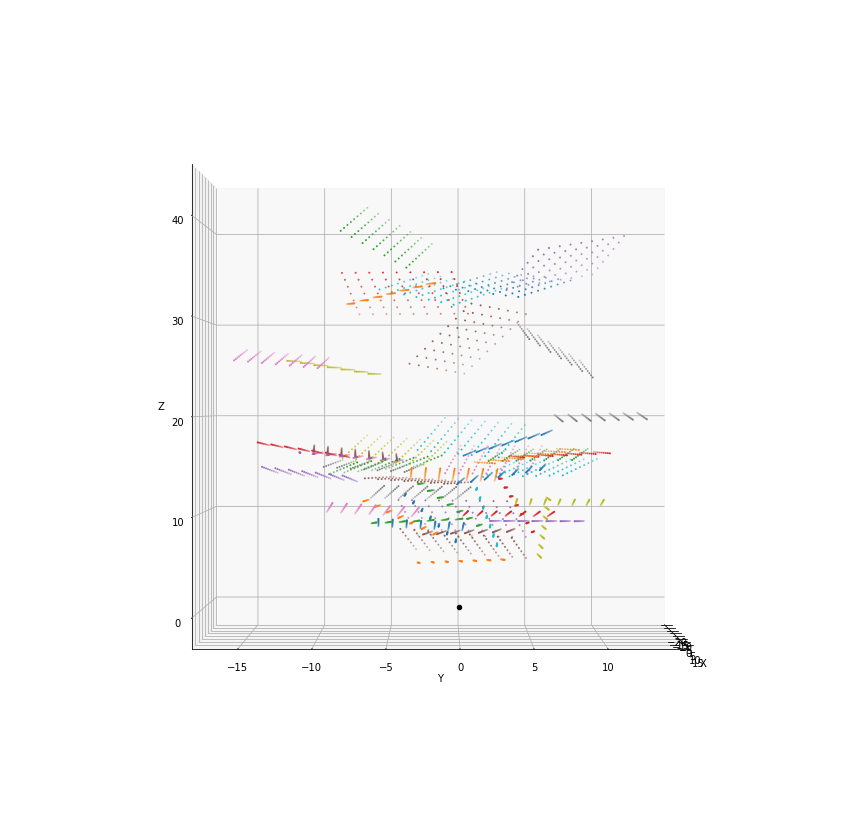

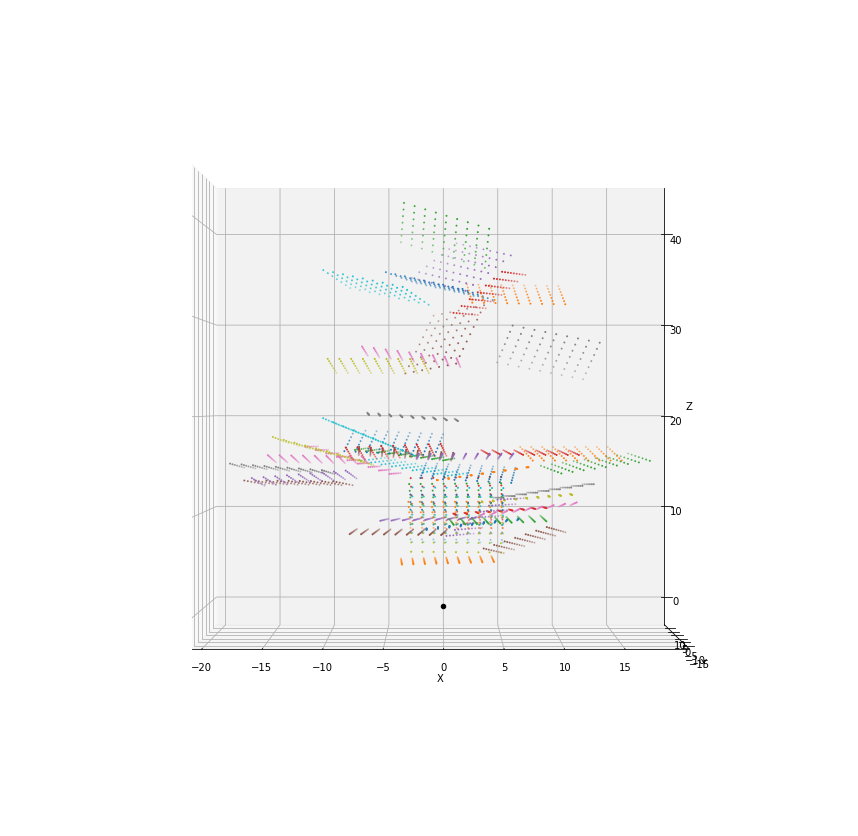

In [4]:
display_calibration_boards(3)

In [ ]:
display_calibration_boards(4)

In [ ]:
display_calibration_boards(5)

camera 6
73 images


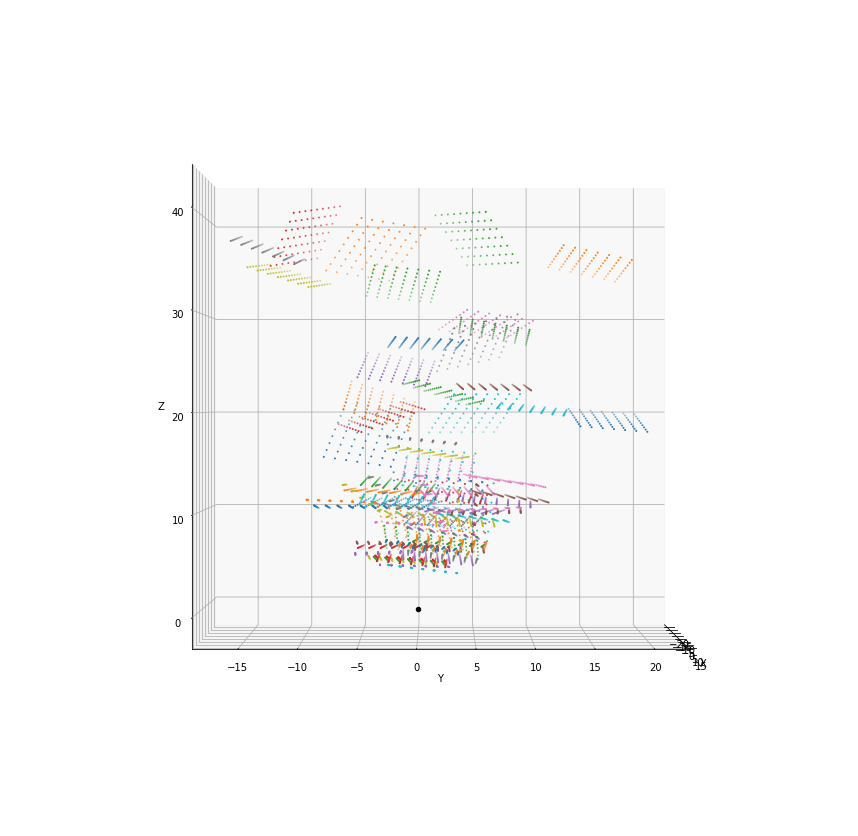

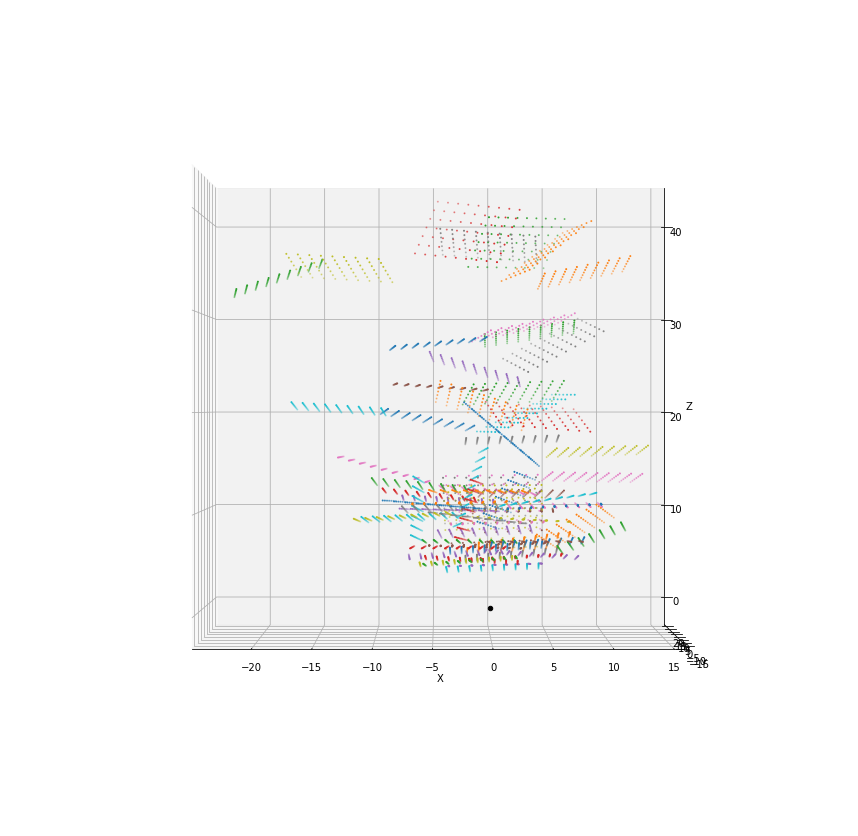

In [2]:
display_calibration_boards(6)